In [ ]:
# Сколько символов поместится в ваш блокнот?
width = 90
print('A'*width)

import numpy as np

np.set_printoptions(linewidth=width)
np.arange(width)

In [ ]:
import pandas as pd
pd.options.display.width = width - 10
pd.options.display.max_colwidth = width - 10
pd.DataFrame([{'col': 'A' * (width-11)}])

# Установка, запуск, предобработка

In [ ]:
!apt-get install -q openjdk-8-jdk-headless
!wget -c https://dlcdn.apache.org/spark/spark-3.4.0/spark-3.4.0-bin-hadoop3.tgz
!if [ ! -d spark-3.4.0-bin-hadoop3 ]; then tar -xzf spark-3.4.0-bin-hadoop3.tgz; fi
!pip install findspark

In [ ]:
import os
import findspark

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.0-bin-hadoop3"
findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark

In [ ]:
ch_train = spark.read.csv('/content/sample_data/california_housing_train.csv', header=True, inferSchema=True)
ch_test = spark.read.csv('/content/sample_data/california_housing_test.csv', header=True, inferSchema=True)

ch = ch_train.union(ch_test)
ch.printSchema()

In [ ]:
ch.sample(False, 0.001, seed=0).show()

In [ ]:
ch = ch.withColumn("median_house_value", ch["median_house_value"]/100000)
ch = ch.withColumn('rooms_per_household', ch["total_rooms"]/ch["households"])
ch = ch.withColumn('population_per_household', ch["population"]/ch["households"]) # средний размер семьи
ch = ch.withColumn('bedrooms_per_room', ch["total_bedrooms"]/ch["total_rooms"])

In [ ]:
ch = ch.select("median_house_value", 
              "total_bedrooms", 
              "population", 
              "households", 
              "median_income", 
              "rooms_per_household", 
              "population_per_household", 
              "bedrooms_per_room")

ch.show(5)

# Регрессия

In [ ]:
import inspect
from pyspark.ml.regression import LinearRegression

inspect.signature(LinearRegression).parameters

In [ ]:
from pyspark.ml.linalg import DenseVector

input_data = ch.rdd.map(lambda x: (x[0], DenseVector(x[1:])))

ch_vectors = spark.createDataFrame(input_data, ["label", "features"])

In [ ]:
ch_vectors.show(truncate=100)

In [ ]:
from pyspark.ml.feature import StandardScaler

standardScaler = StandardScaler(inputCol="features", outputCol="features_scaled", withStd=True, withMean=True)

scaler = standardScaler.fit(ch_vectors)

scaled_ch = scaler.transform(ch_vectors)

scaled_ch.show(15, truncate=100)

In [ ]:
train_ch, test_ch = scaled_ch.randomSplit([0.8, 0.2], seed=13)

In [ ]:
train_ch.count(), test_ch.count()

In [ ]:
train_ch.printSchema()

In [ ]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol='features_scaled', labelCol="label", regParam=0.3, elasticNetParam=0.8)

linearModel = lr.fit(train_ch)

In [ ]:
predicted = linearModel.transform(test_ch)

In [ ]:
predicted.printSchema()

In [ ]:
predicted.sample(0.001).show()

In [ ]:
linearModel.coefficients

In [ ]:
linearModel.intercept

In [ ]:
evaluation_summary = linearModel.evaluate(test_ch)

In [ ]:
evaluation_summary.meanSquaredError

# Pipeline

In [ ]:
ch.printSchema()

In [ ]:
from pyspark.ml.feature import VectorAssembler

input_cols = ch.columns[1:]

assembler = VectorAssembler(inputCols=input_cols, outputCol="features")
assembler.transform(ch).show(3, truncate=50)

In [ ]:
ch_vectors = assembler.transform(ch).select('median_house_value', 'features')
ch_vectors.show(3, 100)

In [ ]:
from pyspark.ml.feature import SQLTransformer

project_sql = SQLTransformer(statement="SELECT median_house_value as label, features FROM __THIS__")

In [ ]:
lr.getLabelCol()

In [ ]:
lr.setLabelCol('median_house_value')

In [ ]:
lr.getLabelCol()

In [ ]:
train_ch, test_ch = ch.randomSplit([0.8, 0.2], seed=13)

In [ ]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[assembler,
                            # project_sql,
                            standardScaler,
                            lr])

In [ ]:
model = pipeline.fit(train_ch)

In [ ]:
prediction = model.transform(test_ch)

In [ ]:
prediction.show(5)

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol="median_house_value", predictionCol="prediction", metricName="mse")
mse = evaluator.evaluate(prediction)
mse

# Кросс-Валидация 

In [ ]:
pipeline = Pipeline(stages=[assembler, standardScaler, lr])

[целевая функция](<https://spark.apache.org/docs/latest/api/scala/org/apache/spark/ml/regression/LinearRegression.html>)

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder

paramGrid = ParamGridBuilder()\
  .addGrid(lr.regParam, [0.01, 0.05, 0.15, 0.3, 0.5, 0.75, 1])\
  .addGrid(lr.elasticNetParam, [0, 0.15, 0.3, 0.5, 0.8, 1])\
  .build()

In [ ]:
from pyspark.ml.tuning import CrossValidator

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

In [ ]:
cvModel = crossval.fit(train_ch)

In [ ]:
cvModel.bestModel

In [ ]:
cvModel.bestModel.stages

In [ ]:
opt_model = cvModel.bestModel.stages[-1]
opt_model.getRegParam(), opt_model.getElasticNetParam()

In [ ]:
prediction = cvModel.transform(test_ch)

In [ ]:
prediction.sample(0.01).show()

In [ ]:
evaluator.evaluate(prediction)

# Классификация 

In [ ]:
!wget -c https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/stuff/titanic.csv

In [ ]:
titanic = spark.read.csv('/content/titanic.csv', header=True, inferSchema=True)
titanic.show(5)

In [ ]:
titanic = titanic.drop('Name')

In [ ]:
titanic.show(5)

In [ ]:
titanic = titanic\
  .withColumnRenamed('Siblings/Spouses Aboard', 'SibSp')\
  .withColumnRenamed('Parents/Children Aboard', 'ParCh')

In [ ]:

titanic.printSchema()

In [ ]:
titanic.show(5)

In [ ]:
titanic_train, titanic_test = titanic.randomSplit([0.75, 0.25], seed=13)

In [ ]:
titanic_train.count(), titanic_test.count()

In [ ]:
# from pyspark.ml.feature import OneHotEncoder

# encoder = OneHotEncoder(inputCol="Sex")
# ohe = encoder.fit(titanic_train)
# ohe.transform(titanic_train).show(5)

In [ ]:
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol="Sex", outputCol="SexIndexer")
indexed = indexer.fit(titanic_train).transform(titanic_train)

In [ ]:
indexed.show(5)

In [ ]:
indexed.printSchema()

In [ ]:
from pyspark.ml.feature import OneHotEncoder

encoder = OneHotEncoder(inputCol="SexIndexer", outputCol="SexVector")
ohe = encoder.fit(indexed)
ohe.transform(indexed).sample(False, 0.1, seed=0).show()

In [ ]:
titanic_train = ohe.transform(indexed).drop('Sex', 'SexIndexer')
titanic_train.show(5)

In [ ]:
titanic_train.printSchema()

In [ ]:
from pyspark.ml.feature import VectorAssembler

input_cols = titanic_train.columns[1:]

assembler = VectorAssembler(inputCols=input_cols, outputCol="features")
titanic_train_vec = assembler.transform(titanic_train)

In [ ]:
titanic_train_vec.show(3)

In [ ]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(regParam=0.01, elasticNetParam=0.5, labelCol='Survived')

In [ ]:
lrModel = lr.fit(titanic_train_vec)

In [ ]:
lrModel.coefficients

In [ ]:
lrModel.intercept

In [ ]:
trainingSummary = lrModel.summary

In [ ]:
trainingSummary.accuracy

In [ ]:
trainingSummary.roc.show()

In [ ]:
from matplotlib import pyplot as plt

roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

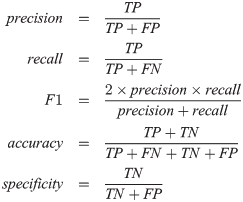

In [ ]:
lrModel.getThreshold()

In [ ]:
trainingSummary.pr.show()

In [ ]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

[The Relationship Between Precision-Recall and ROC Curves](<http://pages.cs.wisc.edu/~jdavis/davisgoadrichcamera2.pdf>)

In [ ]:
prediction = lrModel.transform(titanic_train_vec)

In [ ]:
prediction.show()

<https://spark.apache.org/docs/3.1.1/ml-tuning.html#model-selection-aka-hyperparameter-tuning>

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol="Survived", rawPredictionCol="prediction", metricName="areaUnderROC")
evaluator.evaluate(prediction)

# Полезные возможности 

In [ ]:
from pyspark.ml.feature import Imputer

df = spark.createDataFrame([
    (1.0, float("nan")),
    (2.0, float("nan")),
    (float("nan"), 3.0),
    (4.0, 4.0),
    (5.0, 5.0)
], ["a", "b"])

imputer = Imputer(inputCols=["a", "b"], outputCols=["out_a", "out_b"])
model = imputer.fit(df)

model.transform(df).show()

In [ ]:
from pyspark.ml.feature import VectorSlicer
from pyspark.ml.linalg import Vectors
from pyspark.sql.types import Row

df = spark.createDataFrame([
    Row(userFeatures=Vectors.sparse(3, {0: -2.0, 1: 2.3})),
    Row(userFeatures=Vectors.dense([-2.0, 2.3, 0.0]))
])

slicer = VectorSlicer(inputCol="userFeatures", outputCol="features", indices=[1])

output = slicer.transform(df)

output.select("userFeatures", "features").show()

# Задание
1. Собрать все этапы из раздела "Классификация" в `Pipeline`
2. Применить для классификации данных титаника RandomForest
3. Найти и сравнить F1-score для логистической регрессии (то, что есть сейчас) и случанйого леса (задание 2)